In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip -u "/content/drive/MyDrive/FreiHAND_pub_v2.zip" -d "/content/FreiHAND_pub_v2"



Streaming output truncated to the last 5000 lines.
  inflating: /content/FreiHAND_pub_v2/FreiHAND_pub_v2/evaluation/rgb/00003815.jpg  
  inflating: /content/FreiHAND_pub_v2/__MACOSX/FreiHAND_pub_v2/evaluation/rgb/._00003815.jpg  
  inflating: /content/FreiHAND_pub_v2/FreiHAND_pub_v2/evaluation/rgb/00003801.jpg  
  inflating: /content/FreiHAND_pub_v2/__MACOSX/FreiHAND_pub_v2/evaluation/rgb/._00003801.jpg  
  inflating: /content/FreiHAND_pub_v2/FreiHAND_pub_v2/evaluation/rgb/00001970.jpg  
  inflating: /content/FreiHAND_pub_v2/__MACOSX/FreiHAND_pub_v2/evaluation/rgb/._00001970.jpg  
  inflating: /content/FreiHAND_pub_v2/FreiHAND_pub_v2/evaluation/rgb/00001780.jpg  
  inflating: /content/FreiHAND_pub_v2/__MACOSX/FreiHAND_pub_v2/evaluation/rgb/._00001780.jpg  
  inflating: /content/FreiHAND_pub_v2/FreiHAND_pub_v2/evaluation/rgb/00001958.jpg  
  inflating: /content/FreiHAND_pub_v2/__MACOSX/FreiHAND_pub_v2/evaluation/rgb/._00001958.jpg  
  inflating: /content/FreiHAND_pub_v2/FreiHAND_pub_v2/

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
from tqdm import tqdm

N_KEYPOINTS = 21
N_IMG_CHANNELS = 3
RAW_IMG_SIZE = 224
MODEL_IMG_SIZE = 128
DATASET_MEANS = [0.3950, 0.4323, 0.2954]
DATASET_STDS = [0.1966, 0.1734, 0.1836]
MODEL_NEURONS = 16


COLORMAP = {
    "thumb": {"ids": [0, 1, 2, 3, 4], "color": "g"},
    "index": {"ids": [0, 5, 6, 7, 8], "color": "c"},
    "middle": {"ids": [0, 9, 10, 11, 12], "color": "b"},
    "ring": {"ids": [0, 13, 14, 15, 16], "color": "m"},
    "little": {"ids": [0, 17, 18, 19, 20], "color": "r"},
}


def projectPoints(xyz, K):
    """
    Projects 3D coordinates into image space.
    Function taken from https://github.com/lmb-freiburg/freihand
    """
    xyz = np.array(xyz)
    K = np.array(K)
    uv = np.matmul(K, xyz.T).T
    return uv[:, :2] / uv[:, -1:]


def get_norm_params(dataloader):
    """
    Calculates image normalization parameters.
    Mean and Std are calculated for each channel separately.
    Borrowed from this StackOverflow discussion:
    https://stackoverflow.com/questions/60101240/finding-mean-and-standard-deviation-across-image-channels-pytorch
    """
    mean = 0.0
    std = 0.0
    nb_samples = 0.0

    for i, sample in tqdm(enumerate(dataloader)):
        data = sample["image_raw"]
        batch_samples = data.size(0)
        data = data.view(batch_samples, data.size(1), -1)
        mean += data.mean(2).sum(0)
        std += data.std(2).sum(0)
        nb_samples += batch_samples

    mean /= nb_samples
    std /= nb_samples
    return {"mean": mean, "std": std}


def vector_to_heatmaps(keypoints):
    """
    Creates 2D heatmaps from keypoint locations for a single image
    Input: array of size N_KEYPOINTS x 2
    Output: array of size N_KEYPOINTS x MODEL_IMG_SIZE x MODEL_IMG_SIZE
    """
    heatmaps = np.zeros([N_KEYPOINTS, MODEL_IMG_SIZE, MODEL_IMG_SIZE])
    for k, (x, y) in enumerate(keypoints):
        x, y = int(x * MODEL_IMG_SIZE), int(y * MODEL_IMG_SIZE)
        if (0 <= x < MODEL_IMG_SIZE) and (0 <= y < MODEL_IMG_SIZE):
            heatmaps[k, int(y), int(x)] = 1

    heatmaps = blur_heatmaps(heatmaps)
    return heatmaps


def blur_heatmaps(heatmaps):
    """Blurs heatmaps using GaussinaBlur of defined size"""
    heatmaps_blurred = heatmaps.copy()
    for k in range(len(heatmaps)):
        if heatmaps_blurred[k].max() == 1:
            heatmaps_blurred[k] = cv2.GaussianBlur(heatmaps[k], (51, 51), 3)
            heatmaps_blurred[k] = heatmaps_blurred[k] / heatmaps_blurred[k].max()
    return heatmaps_blurred


class IoULoss(nn.Module):
    """
    Intersection over Union Loss.
    IoU = Area of Overlap / Area of Union
    IoU loss is modified to use for heatmaps.
    """

    def __init__(self):
        super(IoULoss, self).__init__()
        self.EPSILON = 1e-6

    def _op_sum(self, x):
        return x.sum(-1).sum(-1)

    def forward(self, y_pred, y_true):
        inter = self._op_sum(y_true * y_pred)
        union = (
            self._op_sum(y_true ** 2)
            + self._op_sum(y_pred ** 2)
            - self._op_sum(y_true * y_pred)
        )
        iou = (inter + self.EPSILON) / (union + self.EPSILON)
        iou = torch.mean(iou)
        return 1 - iou


def heatmaps_to_coordinates(heatmaps):
    """
    Heatmaps is a numpy array
    Its size - (batch_size, n_keypoints, img_size, img_size)
    """
    batch_size = heatmaps.shape[0]
    sums = heatmaps.sum(axis=-1).sum(axis=-1)
    sums = np.expand_dims(sums, [2, 3])
    normalized = heatmaps / sums
    x_prob = normalized.sum(axis=2)
    y_prob = normalized.sum(axis=3)

    arr = np.tile(np.float32(np.arange(0, 128)), [batch_size, 21, 1])
    x = (arr * x_prob).sum(axis=2)
    y = (arr * y_prob).sum(axis=2)
    keypoints = np.stack([x, y], axis=-1)
    return keypoints / 128


def show_data(dataset, n_samples=12):
    """
    Function to visualize data
    Input: torch.utils.data.Dataset
    """
    n_cols = 4
    n_rows = int(np.ceil(n_samples / n_cols))
    plt.figure(figsize=[15, n_rows * 4])

    ids = np.random.choice(dataset.__len__(), n_samples, replace=False)
    for i, id_ in enumerate(ids, 1):
        sample = dataset.__getitem__(id_)

        image = sample["image_raw"].numpy()
        image = np.moveaxis(image, 0, -1)
        keypoints = sample["keypoints"].numpy()
        keypoints = keypoints * RAW_IMG_SIZE

        plt.subplot(n_rows, n_cols, i)
        plt.imshow(image)
        plt.scatter(keypoints[:, 0], keypoints[:, 1], c="k", alpha=0.5)
        for finger, params in COLORMAP.items():
            plt.plot(
                keypoints[params["ids"], 0],
                keypoints[params["ids"], 1],
                params["color"],
            )
    plt.tight_layout()
    plt.show()


def show_batch_predictions(batch_data, model):
    """
    Visualizes image, image with actual keypoints and
    image with predicted keypoints.
    Finger colors are in COLORMAP.
    Inputs:
    - batch data is batch from dataloader
    - model is trained model
    """
    inputs = batch_data["image"]
    true_keypoints = batch_data["keypoints"].numpy()
    batch_size = true_keypoints.shape[0]
    pred_heatmaps = model(inputs)
    pred_heatmaps = pred_heatmaps.detach().numpy()
    pred_keypoints = heatmaps_to_coordinates(pred_heatmaps)
    images = batch_data["image_raw"].numpy()
    images = np.moveaxis(images, 1, -1)

    plt.figure(figsize=[12, 4 * batch_size])
    for i in range(batch_size):
        image = images[i]
        true_keypoints_img = true_keypoints[i] * RAW_IMG_SIZE
        pred_keypoints_img = pred_keypoints[i] * RAW_IMG_SIZE

        plt.subplot(batch_size, 3, i * 3 + 1)
        plt.imshow(image)
        plt.title("Image")
        plt.axis("off")

        plt.subplot(batch_size, 3, i * 3 + 2)
        plt.imshow(image)
        for finger, params in COLORMAP.items():
            plt.plot(
                true_keypoints_img[params["ids"], 0],
                true_keypoints_img[params["ids"], 1],
                params["color"],
            )
        plt.title("True Keypoints")
        plt.axis("off")

        plt.subplot(batch_size, 3, i * 3 + 3)
        plt.imshow(image)
        for finger, params in COLORMAP.items():
            plt.plot(
                pred_keypoints_img[params["ids"], 0],
                pred_keypoints_img[params["ids"], 1],
                params["color"],
            )
        plt.title("Pred Keypoints")
        plt.axis("off")
    plt.tight_layout()

In [4]:
class PoseLoss(nn.Module):
    def __init__(self, device, sx=0.0, sq=0.0, learn_beta=False):
        super(PoseLoss, self).__init__()
        self.learn_beta = learn_beta

        if not self.learn_beta:
            self.sx = 0
            self.sq = -6.25
            
        self.sx = nn.Parameter(torch.Tensor([sx]), requires_grad=self.learn_beta)
        self.sq = nn.Parameter(torch.Tensor([sq]), requires_grad=self.learn_beta)

        # if learn_beta:
        #     self.sx.requires_grad = True
        #     self.sq.requires_grad = True
        #
        # self.sx = self.sx.to(device)
        # self.sq = self.sq.to(device)

        self.loss_print = None

    def forward(self, pred_x, pred_q, target_x, target_q):
        pred_q = F.normalize(pred_q, p=2, dim=1)
        loss_x = F.l1_loss(pred_x, target_x)
        loss_q = F.l1_loss(pred_q, target_q)

            
        loss = torch.exp(-self.sx)*loss_x \
               + self.sx \
               + torch.exp(-self.sq)*loss_q \
               + self.sq

        self.loss_print = [loss.item(), loss_x.item(), loss_q.item()]

        return loss

In [76]:
import numpy as np
import os
from PIL import Image
import json
import torch
from torchvision import transforms
from torch.utils.data import Dataset


class FreiHAND(Dataset):
    """
    Class to load FreiHAND dataset. Only training part is used here.
    Augmented images are not used, only raw - first 32,560 images
    Link to dataset:
    https://lmb.informatik.uni-freiburg.de/resources/datasets/FreihandDataset.en.html
    """

    def __init__(self, config, set_type="train"):
        self.device = config["device"]
        self.image_dir = os.path.join(config["data_dir"], "training/rgb")
        self.image_names = np.sort(os.listdir(self.image_dir))

        fn_K_matrix = os.path.join(config["data_dir"], "training/training_K.json")
        with open(fn_K_matrix, "r") as f:
            a = np.array(json.load(f))
        self.K_matrix = np.tile(a,(4,1,1))

        fn_anno = os.path.join(config["data_dir"], "training/training_xyz.json")
        with open(fn_anno, "r") as f:
            a = np.array(json.load(f))
        self.anno = np.tile(a,(4,1,1))

        if set_type == "train":
            n_start = 0
            n_end = 104000
        elif set_type == "val":
            n_start = 104000
            n_end = 117000
        else:
            n_start = 117000
            n_end = len(self.anno)
            
        #n_start = 0
        #n_end = 4
        self.image_names = self.image_names[n_start:n_end]
        self.K_matrix = self.K_matrix[n_start:n_end]
        self.anno = self.anno[n_start:n_end]

        self.image_raw_transform = transforms.ToTensor()
        self.image_transform = transforms.Compose(
            [
                transforms.Resize(MODEL_IMG_SIZE),
                transforms.ToTensor(),
                transforms.Normalize(mean=DATASET_MEANS, std=DATASET_STDS),

            ]
        )

    def __len__(self):
        return len(self.anno)

    def __getitem__(self, idx):
        image_name = self.image_names[idx]
        image_raw = Image.open(os.path.join(self.image_dir, image_name))
        image = self.image_transform(image_raw)
        image_raw = self.image_raw_transform(image_raw)
        
        keypoints = projectPoints(self.anno[idx], self.K_matrix[idx])
        keypoints = keypoints / RAW_IMG_SIZE
        heatmaps = vector_to_heatmaps(keypoints)
        keypoints = torch.from_numpy(keypoints)
        heatmaps = torch.from_numpy(np.float32(heatmaps))

        return {
            "image": image,
            "keypoints": keypoints,
            "heatmaps": heatmaps,
            "image_name": image_name,
            "image_raw": image_raw,
        }

In [6]:
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn

import sys
sys.path.append("../")

In [58]:
config = {
    "data_dir": "/content/FreiHAND_pub_v2/FreiHAND_pub_v2",
    "epochs": 500,
    "batch_size": 32,
    "batches_per_epoch": 50,
    "batches_per_epoch_val": 20,
    "learning_rate": 0.1,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
}

In [59]:
train_dataset = FreiHAND(config=config, set_type="train")
train_dataloader = DataLoader(
    train_dataset, config["batch_size"], shuffle=True, drop_last=True, num_workers=2
)

val_dataset = FreiHAND(config=config, set_type="val")
val_dataloader = DataLoader(
    val_dataset, config["batch_size"], shuffle=True, drop_last=True, num_workers=2
)

In [60]:
train_dataloader

In [61]:
show_data(train_dataset, n_samples=8)

In [62]:
class Trainer:
    def __init__(self, model, criterion, optimizer, config, scheduler=None):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.loss = {"train": [], "val": []}
        self.epochs = config["epochs"]
        self.batches_per_epoch = config["batches_per_epoch"]
        self.batches_per_epoch_val = config["batches_per_epoch_val"]
        self.device = config["device"]
        self.scheduler = scheduler
        self.checkpoint_frequency = 100
        self.early_stopping_epochs = 10
        self.early_stopping_avg = 10
        self.early_stopping_precision = 5

    def train(self, train_dataloader, val_dataloader):
        for epoch in range(self.epochs):
            self._epoch_train(train_dataloader)
            self._epoch_eval(val_dataloader)
            print(
                "Epoch: {}/{}, Train Loss={}, Val Loss={}".format(
                    epoch + 1,
                    self.epochs,
                    np.round(self.loss["train"][-1], 10),
                    np.round(self.loss["val"][-1], 10),
                )
            )

            # reducing LR if no improvement
            if self.scheduler is not None:
                self.scheduler.step(self.loss["train"][-1])

            # saving model
            if (epoch + 1) % self.checkpoint_frequency == 0:
                torch.save(
                    self.model.state_dict(), "model_{}".format(str(epoch + 1).zfill(3))
                )

            # early stopping
            if epoch < self.early_stopping_avg:
                min_val_loss = np.round(np.mean(self.loss["val"]), self.early_stopping_precision)
                no_decrease_epochs = 0

            else:
                val_loss = np.round(
                    np.mean(self.loss["val"][-self.early_stopping_avg:]), 
                                    self.early_stopping_precision
                )
                if val_loss >= min_val_loss:
                    no_decrease_epochs += 1
                else:
                    min_val_loss = val_loss
                    no_decrease_epochs = 0
                    #print('New min: ', min_val_loss)

            if no_decrease_epochs > self.early_stopping_epochs:
                print("Early Stopping")
                break

        torch.save(self.model.state_dict(), "model_final")
        return self.model

    def _epoch_train(self, dataloader):
        self.model.train()
        running_loss = []

        for i, data in enumerate(dataloader, 0):
            inputs = data["image"].to(self.device)
            labels = data["heatmaps"].to(self.device)

            self.optimizer.zero_grad()
            running_loss = []

            outputs = self.model(inputs)
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()

            running_loss.append(loss.item())

            if i == self.batches_per_epoch:
                epoch_loss = np.mean(running_loss)
                self.loss["train"].append(epoch_loss)
                break

    def _epoch_eval(self, dataloader):
        self.model.eval()
        running_loss = []

        with torch.no_grad():
            for i, data in enumerate(dataloader, 0):
                inputs = data["image"].to(self.device)
                labels = data["heatmaps"].to(self.device)

                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)

                running_loss.append(loss.item())

                if i == self.batches_per_epoch_val:
                    epoch_loss = np.mean(running_loss)
                    self.loss["val"].append(epoch_loss)
                    break

In [63]:
class ConvBlock(nn.Module):
    def __init__(self, in_depth, out_depth):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_depth, out_depth, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_depth),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_depth, out_depth, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_depth),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_depth, out_depth, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_depth),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_depth, out_depth, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_depth),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)


class ShallowUNet(nn.Module):
    """
    Implementation of UNet, slightly modified:
    - less downsampling blocks
    - less neurons in the layers
    - Batch Normalization added
    
    Link to paper on original UNet:
    https://arxiv.org/abs/1505.04597
    """
    
    def __init__(self, in_channel, out_channel):
        super().__init__()

        self.conv_down1 = ConvBlock(in_channel, MODEL_NEURONS)
        self.conv_down2 = ConvBlock(MODEL_NEURONS, MODEL_NEURONS * 2)
        self.conv_down3 = ConvBlock(MODEL_NEURONS * 2, MODEL_NEURONS * 4)
        self.conv_down4 = ConvBlock(MODEL_NEURONS * 4, MODEL_NEURONS * 8)
        self.conv_down5 = ConvBlock(MODEL_NEURONS * 8, MODEL_NEURONS * 16)
        self.conv_bottleneck = ConvBlock(MODEL_NEURONS * 16, MODEL_NEURONS * 32)

        self.maxpool = nn.MaxPool2d(2)
        self.upsamle = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=False)

        self.conv_up1 = ConvBlock(
            MODEL_NEURONS * 32 + MODEL_NEURONS * 16, MODEL_NEURONS * 16
        )
        self.conv_up2 = ConvBlock(
            MODEL_NEURONS * 16 + MODEL_NEURONS * 8, MODEL_NEURONS * 8
        )
        self.conv_up3 = ConvBlock(
            MODEL_NEURONS * 8 + MODEL_NEURONS * 4, MODEL_NEURONS * 4
        )
        self.conv_up4 = ConvBlock(
            MODEL_NEURONS * 4 + MODEL_NEURONS * 2, MODEL_NEURONS * 2
        )
        self.conv_up5 = ConvBlock(MODEL_NEURONS * 2 + MODEL_NEURONS, MODEL_NEURONS)

        self.conv_out = nn.Sequential(
            nn.Conv2d(MODEL_NEURONS, out_channel, kernel_size=3, padding=1, bias=False),
            nn.Sigmoid(),
        )

    def forward(self, x):
        conv_d1 = self.conv_down1(x)
        conv_d2 = self.conv_down2(self.maxpool(conv_d1))
        conv_d3 = self.conv_down3(self.maxpool(conv_d2))
        conv_d4 = self.conv_down4(self.maxpool(conv_d3))
        conv_d5 = self.conv_down5(self.maxpool(conv_d4))
        conv_b = self.conv_bottleneck(self.maxpool(conv_d5))
        conv_u1 = self.conv_up1(torch.cat([self.upsamle(conv_b), conv_d5], dim=1))
        conv_u2 = self.conv_up2(torch.cat([self.upsamle(conv_u1), conv_d4], dim=1))
        conv_u3 = self.conv_up3(torch.cat([self.upsamle(conv_u2), conv_d3], dim=1))
        conv_u4 = self.conv_up4(torch.cat([self.upsamle(conv_u3), conv_d2], dim=1))
        conv_u5 = self.conv_up5(torch.cat([self.upsamle(conv_u4), conv_d1], dim=1))
        out = self.conv_out(conv_u5)
        return out

In [64]:
model = ShallowUNet(N_IMG_CHANNELS, N_KEYPOINTS)
model = model.to(config["device"])

criterion = IoULoss()
optimizer = optim.Adadelta(model.parameters(), lr=config["learning_rate"])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer=optimizer, factor=0.5, patience=20, verbose=True, threshold=0.00001
)

In [65]:
trainer = Trainer(model, criterion, optimizer, config, scheduler)

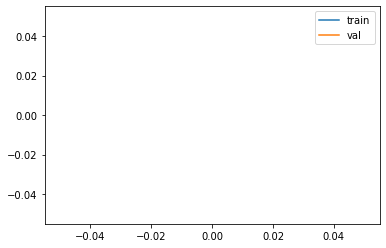

In [66]:
plt.plot(trainer.loss["train"], label="train")
plt.plot(trainer.loss["val"], label="val")
plt.legend()
plt.show()

In [67]:
model = trainer.train(train_dataloader, val_dataloader)

Epoch: 1/500, Train Loss=0.9930127263, Val Loss=0.9929142027
Epoch: 2/500, Train Loss=0.9929032922, Val Loss=0.9929143247
Epoch: 3/500, Train Loss=0.9928436279, Val Loss=0.9928345368
Epoch: 4/500, Train Loss=0.9926878214, Val Loss=0.9927621001
Epoch: 5/500, Train Loss=0.9924275875, Val Loss=0.9926746459
Epoch: 6/500, Train Loss=0.9922735095, Val Loss=0.9925764771
Epoch: 7/500, Train Loss=0.9920402169, Val Loss=0.9924905215
Epoch: 8/500, Train Loss=0.9918033481, Val Loss=0.9923840023
Epoch: 9/500, Train Loss=0.9913069606, Val Loss=0.9921825386
Epoch: 10/500, Train Loss=0.9908469915, Val Loss=0.9911907173
Epoch: 11/500, Train Loss=0.9905696511, Val Loss=0.9917269491
Epoch: 12/500, Train Loss=0.9895300269, Val Loss=0.9913338849
Epoch: 13/500, Train Loss=0.9896391034, Val Loss=0.9905365024
Epoch: 14/500, Train Loss=0.9885208011, Val Loss=0.9901611464
Epoch: 15/500, Train Loss=0.9867628813, Val Loss=0.988340182
Epoch: 16/500, Train Loss=0.9855344296, Val Loss=0.9863935851
Epoch: 17/500, Tra

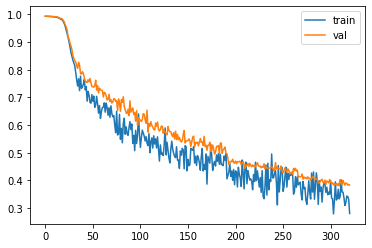

In [68]:
plt.plot(trainer.loss["train"], label="train")
plt.plot(trainer.loss["val"], label="val")
plt.legend()
plt.show()

In [69]:
!pip install torchviz
from torchviz import make_dot

In [70]:
batch = next(iter(train_dataloader))
yhat = model(batch['image'].to(config['device'])) # Give dummy batch to forward().
make_dot(yhat, params=dict(list(model.named_parameters()))).render("mit_viz2", format="png")

'mit_viz2.png'

In [71]:
from PIL import Image
Image.open('/content/mit_viz2.png')

In [72]:
!pip install hiddenlayer
import hiddenlayer as hl

In [73]:
transforms = [ hl.transforms.Prune('Constant') ] # Removes Constant nodes from graph.
graph = hl.build_graph(model, batch['image'].to(config['device']), transforms=transforms)
graph.theme = hl.graph.THEMES['blue'].copy()
graph.save('mit_viz3', format='png')

/usr/local/lib/python3.7/dist-packages/torch/onnx/symbolic_helper.py:715: UserWarning: ONNX export mode is set to inference mode, but operator batch_norm is set to inference mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")
/usr/local/lib/python3.7/dist-packages/torch/onnx/symbolic_helper.py:375: UserWarning: You are trying to export the model with onnx:Upsample for ONNX opset version 9. This operator might cause results to not match the expected results by PyTorch.
ONNX's Upsample/Resize operator did not match Pytorch's Interpolation until opset 11. Attributes to determine how to transform the input were added in onnx:Resize in opset 11 to support Pytorch's behavior (like coordinate_transformation_mode and nearest_mode).
We recommend using opset 11 and above for models using this operator. 
  "" + str(_export_onnx_opset_version) + ". "


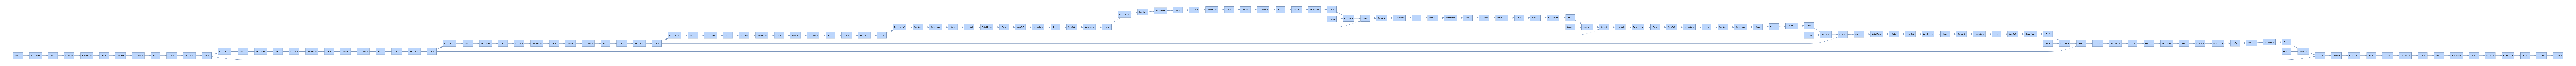

In [74]:
Image.open('/content/mit_viz3.png')

In [75]:
config = {
    "data_dir": "/content/FreiHAND_pub_v2/FreiHAND_pub_v2",
    "model_path": "/content/model_final",
    "test_batch_size": 4,
    "device": "cpu",
}

In [77]:
test_dataset = FreiHAND(config=config, set_type="test")
test_dataloader = DataLoader(
    test_dataset,
    config["test_batch_size"],
    shuffle=True,
    drop_last=False,
    num_workers=2,
)

In [78]:
model = ShallowUNet(3, 21)
model.load_state_dict(
    torch.load(config["model_path"], map_location=torch.device(config["device"]))
)
model.eval()
print("Model loaded")

Model loaded


In [79]:
accuracy_all = []

for data in tqdm(test_dataloader):
    inputs = data["image"]
    pred_heatmaps = model(inputs)
    pred_heatmaps = pred_heatmaps.detach().numpy()
    true_keypoints = data["keypoints"].numpy()
    pred_keypoints = heatmaps_to_coordinates(pred_heatmaps)

    accuracy_keypoint = ((true_keypoints - pred_keypoints) ** 2).sum(axis=2) ** (1 / 2)
    accuracy_image = accuracy_keypoint.mean(axis=1)
    accuracy_all.extend(list(accuracy_image))

100%|██████████| 3310/3310 [13:27<00:00,  4.10it/s]


In [80]:
np.moveaxis(data["image_raw"].numpy(), 1, -1).shape

(4, 224, 224, 3)

In [81]:
len(accuracy_all)

13240

In [46]:
sum(errorper)/len(accuracy_all)

4.756154296698415

0
1
2
3
4
5
6
7
8
9
10
11
12
13


In [82]:
def plot1kerror(accuracy_all):
  errorper = [x*100 for x in accuracy_all]
  error1k = []
  for i in range(0, 13):
    k=i+1
    p = errorper[i*1000:k*1000]
    mp = sum(p)/len(p)
    error1k.append(mp)
  pp = errorper[13*1000:]
  mpp = sum(pp)/len(pp)
  error1k.append(mpp)
  plt.plot(error1k)

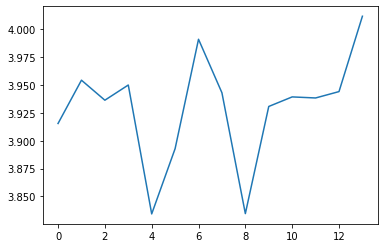

In [83]:
plot1kerror(accuracy_all)

In [84]:
inputs.shape

torch.Size([4, 3, 128, 128])

In [85]:
error = np.mean(accuracy_all)
print("Average error per keypoint: {:.1f}% from image size".format(error * 100))

for img_size in [MODEL_IMG_SIZE, RAW_IMG_SIZE]:
    error_pixels = error * img_size
    image_size = f"{img_size}x{img_size}"
    print(
        "Average error per keypoint: {:.0f} pixels for image {}".format(
            error_pixels, image_size
        )
    )

Average error per keypoint: 3.9% from image size
Average error per keypoint: 5 pixels for image 128x128
Average error per keypoint: 9 pixels for image 224x224


In [86]:
for data in test_dataloader:
    show_batch_predictions(data, model)
    break

In [ ]:
img = cv2.imread('/content/hand test 1.jpg')
img = cv2.resize(img, (128,128))

In [ ]:
tfms = transforms.Compose([
        transforms.ToTensor()])

In [ ]:
 img_tensor = tfms(img).unsqueeze(0)

In [ ]:
img_tensor.shape

torch.Size([1, 3, 128, 128])

In [ ]:
model.eval()

ShallowUNet(
  (conv_down1): ConvBlock(
    (double_conv): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (7): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU(inplace=True)
      (9): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (10): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): ReLU(inplace=True)
    )
  )
  (conv_down2): ConvBlock(
    (double_conv): Sequential(
      (0): Conv2d(16

In [ ]:
pred_heatmaps = model(img_tensor)

In [ ]:
pred_heatmaps = pred_heatmaps.detach().numpy()
pred_keypoints = heatmaps_to_coordinates(pred_heatmaps)

In [ ]:
pred_keypoints[0]

array([[0.638856  , 0.4587235 ],
       [0.61823356, 0.46331584],
       [0.5721208 , 0.47529736],
       [0.52920043, 0.4793051 ],
       [0.5171336 , 0.4686996 ],
       [0.4825927 , 0.45959   ],
       [0.42603344, 0.4662276 ],
       [0.38305864, 0.48265922],
       [0.34607866, 0.49388373],
       [0.4704096 , 0.47520864],
       [0.41225553, 0.5055766 ],
       [0.3687734 , 0.5327141 ],
       [0.31942302, 0.55403906],
       [0.4769191 , 0.50867486],
       [0.43013406, 0.52890414],
       [0.39258903, 0.5652259 ],
       [0.36149493, 0.5904604 ],
       [0.48605785, 0.52116823],
       [0.45166546, 0.55221367],
       [0.4270441 , 0.5855655 ],
       [0.42815846, 0.5909041 ]], dtype=float32)

In [ ]:
N_KEYPOINTS = 21
N_IMG_CHANNELS = 3
RAW_SIZE = 224
MODEL_IMG_SIZE = 128


COLORMAP = {
    "thumb": {"ids": [0, 1, 2, 3, 4], "color": "g"},
    "index": {"ids": [0, 5, 6, 7, 8], "color": "c"},
    "middle": {"ids": [0, 9, 10, 11, 12], "color": "b"},
    "ring": {"ids": [0, 13, 14, 15, 16], "color": "m"},
    "little": {"ids": [0, 17, 18, 19, 20], "color": "r"},
}

def show_pred(impath):
    """
    Visualizes image, image with actual keypoints and
    image with predicted keypoints.
    Finger colors are in COLORMAP.
    Inputs:
    - batch data is batch from dataloader
    - model is trained model
    """
    img = Image.open(impath)
    img = img.resize((224,224))
    tfms = transforms.Compose([
      transforms.Resize(MODEL_IMG_SIZE),                         
      transforms.ToTensor(),
      transforms.Normalize(mean=DATASET_MEANS, std=DATASET_STDS),
      ])
    img_tensor = tfms(img).unsqueeze(0)
    plt.imshow(np.moveaxis(img_tensor.numpy(), 1, -1)[0])
    print(img_tensor.shape)
    pred_heatmaps = model(img_tensor)
    pred_heatmaps = pred_heatmaps.detach().numpy()
    pred_keypoints = heatmaps_to_coordinates(pred_heatmaps)
    image = img
    pred_keypoints_img = pred_keypoints[0] * 224

    plt.imshow(image)
    for finger, params in COLORMAP.items():
        plt.plot(
            pred_keypoints_img[params["ids"], 0],
            pred_keypoints_img[params["ids"], 1],
            params["color"],
        )
    plt.title("Pred Keypoints")
    plt.axis("off")
plt.tight_layout()

<Figure size 432x288 with 0 Axes>

In [ ]:
show_pred('/content/hand test 1.jpg')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 128, 128])


In [ ]:
a

array([[68.331924, 65.07517 ],
       [64.69806 , 64.10181 ],
       [67.14549 , 60.7915  ],
       [69.64934 , 60.177208],
       [69.355064, 61.31698 ],
       [60.519295, 61.405155],
       [60.395405, 62.918907],
       [60.63851 , 63.803078],
       [59.673916, 64.424515],
       [60.58967 , 61.8376  ],
       [59.37506 , 63.964893],
       [58.58307 , 65.10536 ],
       [57.89082 , 65.24715 ],
       [61.512688, 62.60705 ],
       [59.85051 , 64.20207 ],
       [59.06366 , 65.288315],
       [59.4013  , 64.74147 ],
       [61.841213, 63.283546],
       [59.63597 , 64.78788 ],
       [59.29385 , 66.25217 ],
       [61.496086, 64.85988 ]], dtype=float32)